In [7]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

In [8]:

# Load the dataset
data_path = '/kaggle/input/loan-default/Loan_default.csv'  # Adjust path if needed
loan_data = pd.read_csv(data_path)

In [9]:
# Encode categorical variables
categorical_columns = [
    "Education", "EmploymentType", "MaritalStatus", "HasMortgage", 
    "HasDependents", "LoanPurpose", "HasCoSigner"
]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    loan_data[col] = le.fit_transform(loan_data[col])
    label_encoders[col] = le

In [10]:
# Define feature set and target variable
X = loan_data.drop(columns=["LoanID", "Default"])
y = loan_data["Default"]

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Train a logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [13]:
# Predict probabilities and labels on the test set
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
y_pred = logistic_model.predict(X_test)


In [14]:
# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_result = classification_report(y_test, y_pred)

In [15]:
print(f"ROC-AUC Score: {roc_auc}")
print("\nClassification Report:")
print(classification_report_result)

ROC-AUC Score: 0.7336714445991227

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45170
           1       0.21      0.67      0.32      5900

    accuracy                           0.67     51070
   macro avg       0.58      0.67      0.55     51070
weighted avg       0.86      0.67      0.73     51070



In [16]:
# Save predictions for submission
output = pd.DataFrame({'Default_Probability': y_pred_proba, 'Actual_Default': y_test})
output.to_csv('loan_default_predictions.csv', index=False)
print("Predictions saved as loan_default_predictions.csv")

Predictions saved as loan_default_predictions.csv


****

# **Optimizing the model**

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Define profit and loss parameters
approval_income = 30  # Income for each approved loan
default_loss_min = 50  # Minimum loss for default
default_loss_max = 1000  # Maximum loss for default

In [19]:
# Simulate random losses for defaults
np.random.seed(42)  # For reproducibility
random_losses = np.random.randint(default_loss_min, default_loss_max + 1, size=y_test.shape)


In [20]:
# Function to calculate net profit
def calculate_net_profit(y_true, y_proba, threshold):
    decisions = (y_proba < threshold).astype(int)  # 1: approve, 0: reject
    approvals = decisions.sum()
    
    # Income from approved loans
    income = approvals * approval_income
    
    # Losses from defaults
    default_indices = np.where((y_true == 1) & (decisions == 1))[0]
    losses = random_losses[default_indices].sum()
    
    # Net profit
    return income - losses

In [21]:
# Generate net profit for multiple thresholds
thresholds = np.linspace(0, 1, 100)
net_profits = [calculate_net_profit(y_test.values, y_pred_proba, t) for t in thresholds]

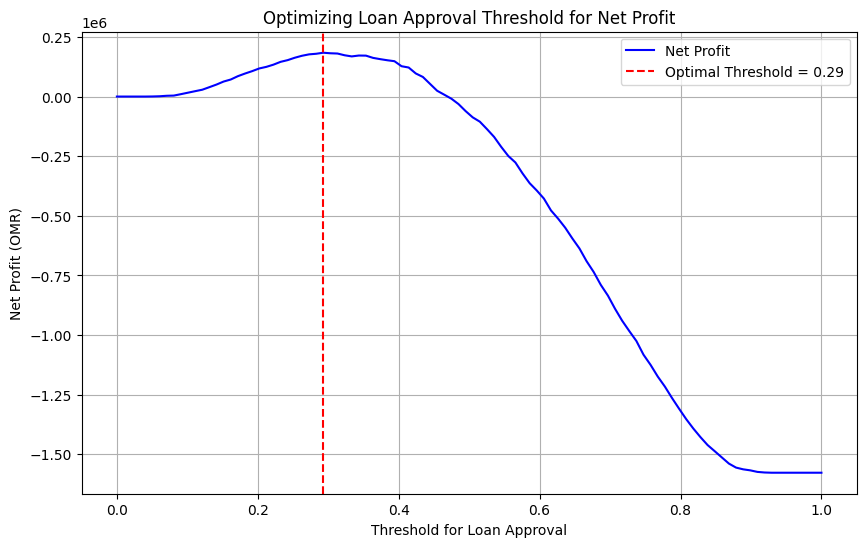

Optimal Threshold: 0.29
Maximum Net Profit: 183772.00 OMR


In [22]:
# Find the optimal threshold
optimal_threshold = thresholds[np.argmax(net_profits)]
max_profit = max(net_profits)

# Plot the net profit vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, net_profits, label="Net Profit", color="blue")
plt.axvline(optimal_threshold, color="red", linestyle="--", label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.xlabel("Threshold for Loan Approval")
plt.ylabel("Net Profit (OMR)")
plt.title("Optimizing Loan Approval Threshold for Net Profit")
plt.legend()
plt.grid()
plt.show()

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Maximum Net Profit: {max_profit:.2f} OMR")

# **Calculating the Net Profit** 

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Define constants for profit and loss
approval_income = 30  # OMR earned for each approved loan
default_loss_min = 50  # Minimum loss if default occurs
default_loss_max = 1000  # Maximum loss if default occurs

In [25]:
# Simulate random losses for defaults
np.random.seed(42)  # For reproducibility
random_losses = np.random.randint(default_loss_min, default_loss_max + 1, size=len(y_test))


In [26]:
# Function to calculate net profit
def calculate_net_profit(y_true, y_proba, threshold):
    """
    Calculate net profit based on threshold.
    - Approve loans with default probability < threshold.
    - Reject loans with default probability >= threshold.
    """
    decisions = (y_proba < threshold).astype(int)  # 1: approve, 0: reject
    
    # Income from approved loans
    approvals = decisions.sum()
    income = approvals * approval_income
    
    # Loss from defaults
    default_indices = np.where((y_true == 1) & (decisions == 1))[0]
    losses = random_losses[default_indices].sum()
    
    # Net profit
    net_profit = income - losses
    return net_profit

In [27]:
# Generate net profit for different thresholds
thresholds = np.linspace(0, 1, 100)  # Threshold values from 0 to 1
net_profits = [calculate_net_profit(y_test.values, y_pred_proba, t) for t in thresholds]

# Find the optimal threshold
optimal_threshold = thresholds[np.argmax(net_profits)]
max_net_profit = max(net_profits)

In [28]:
# Display results
print(f"Optimal Threshold for Approval: {optimal_threshold:.2f}")
print(f"Maximum Net Profit: {max_net_profit:.2f} OMR")

Optimal Threshold for Approval: 0.29
Maximum Net Profit: 183772.00 OMR


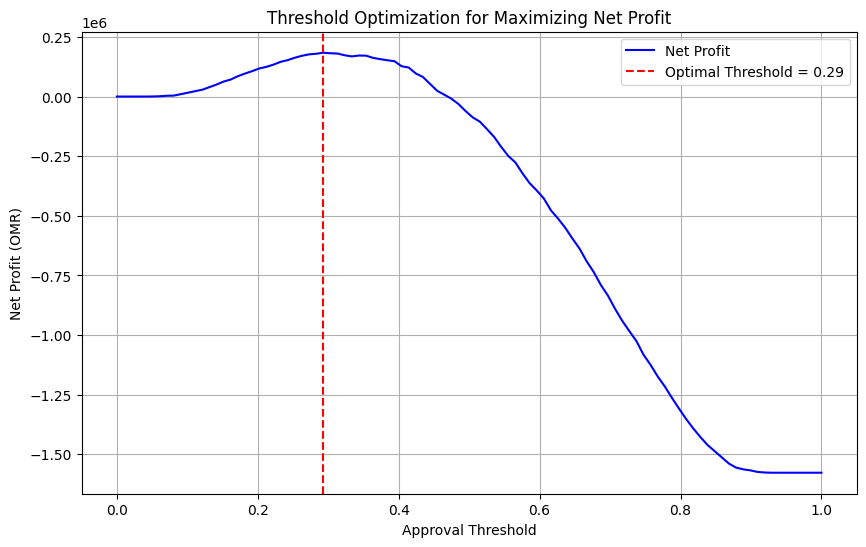

In [29]:
# Plot net profit vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, net_profits, label="Net Profit", color="blue")
plt.axvline(optimal_threshold, color="red", linestyle="--", label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.xlabel("Approval Threshold")
plt.ylabel("Net Profit (OMR)")
plt.title("Threshold Optimization for Maximizing Net Profit")
plt.legend()
plt.grid()
plt.show()

# Model Evaluation

In [43]:
# Function to evaluate model performance
def evaluate_model(y_true, y_proba, random_losses, approval_income, thresholds):
    """
    Evaluate model performance using net profit as the primary metric.
    """
    net_profits = []
    default_rates = []
    approval_rates = []
    
    for threshold in thresholds:
        # Approve loans based on threshold
        decisions = (y_proba < threshold).astype(int)  # 1: approve, 0: reject
        approvals = decisions.sum()
        
        # Income and losses
        income = approvals * approval_income
        default_indices = np.where((y_true == 1) & (decisions == 1))[0]
        losses = random_losses[default_indices].sum()
        
        # Net profit
        net_profit = income - losses
        net_profits.append(net_profit)
        
        # Default rate and approval rate
        default_rate = len(default_indices) / approvals if approvals > 0 else 0
        approval_rate = approvals / len(y_true)
        default_rates.append(default_rate)
        approval_rates.append(approval_rate)
    
    # Optimal threshold
    optimal_idx = np.argmax(net_profits)
    optimal_threshold = thresholds[optimal_idx]
    max_net_profit = net_profits[optimal_idx]
    
    # Print results
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum Net Profit: {max_net_profit:.2f} OMR")
    print(f"Default Rate at Optimal Threshold: {default_rates[optimal_idx]:.2%}")
    print(f"Approval Rate at Optimal Threshold: {approval_rates[optimal_idx]:.2%}")
    
    return thresholds, net_profits, default_rates, approval_rates, optimal_threshold


In [44]:
# Evaluate model
thresholds = np.linspace(0, 1, 100)
results = evaluate_model(
    y_test.values, y_pred_proba, random_losses, approval_income, thresholds
)

Optimal Threshold: 0.29
Maximum Net Profit: 183772.00 OMR
Default Rate at Optimal Threshold: 3.34%
Approval Rate at Optimal Threshold: 26.77%


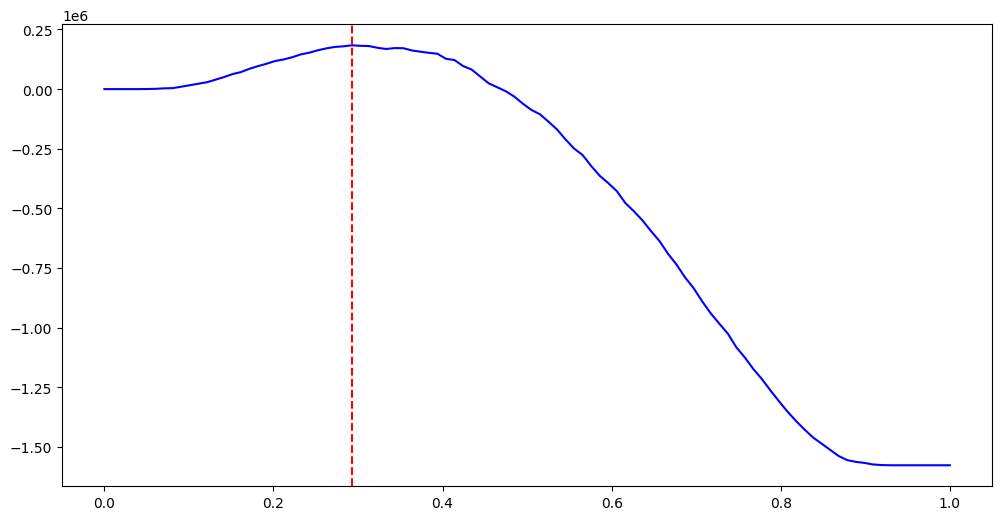

In [45]:
# Plot results
plt.figure(figsize=(12, 6))

# Net profit plot
plt.plot(results[0], results[1], label="Net Profit", color="blue")
plt.axvline(results[4], color="red", linestyle="--", label=f"Optimal Threshold = {results[4]:.2f}")


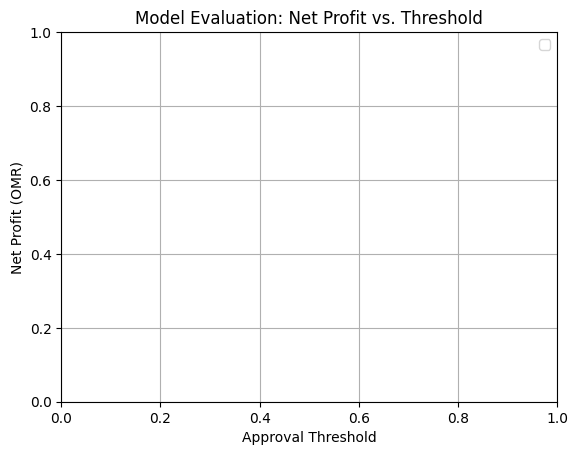

In [46]:
# Labels and legends
plt.xlabel("Approval Threshold")
plt.ylabel("Net Profit (OMR)")
plt.title("Model Evaluation: Net Profit vs. Threshold")
plt.legend()
plt.grid()
plt.show()